In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import joblib
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
plt.style.use('ggplot')

projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"
outputRoot = projectRoot / "ModifiedDataset"

trainOutputPath = outputRoot / "train" / "images"
trainOutputLabelPath = outputRoot / "train" / "labels"
testOutputPath = outputRoot / "test" / "images"
testOutputLabelPath = outputRoot / "test" / "labels"

augDataPath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

# features directory
featuresDir = outputRoot / "features"
featuresDir.mkdir(parents=True, exist_ok=True)

for path in [trainOutputPath, trainOutputLabelPath, testOutputPath, testOutputLabelPath]:
    if not path.exists():
        print(f"Warning: Path {path} does not exist")

print("Paths set up successfully.")



Paths set up successfully.


In [4]:
def compute_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    return hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=visualize,
        feature_vector=True
    )

In [5]:
def extract_dataset_features(image_paths, label_paths, hog_params=None):
    if hog_params is None:
        hog_params = {
            'orientations': 9,
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2)
        }
    
    features = []
    labels = []
    
    #extract features/labels
    for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths), desc="Extracting HOG features"):
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        with open(label_path, 'r') as f:
            label = int(f.read().strip())
        
        # extract HOG features
        hog_features = compute_hog_features(
            image,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block']
        )
        
        features.append(hog_features)
        labels.append(label)
    
    return np.array(features), np.array(labels)

In [6]:
def prepare_dataset_features(dataset_path, output_path, dataset_type, hog_params=None):
    #define paths
    images_path = os.path.join(dataset_path, dataset_type, "images")
    labels_path = os.path.join(dataset_path, dataset_type, "labels")
    
    # get all image files
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpeg')])
    
    image_paths = [os.path.join(images_path, f) for f in image_files]
    label_paths = [os.path.join(labels_path, f.replace('.jpeg', '.txt')) for f in image_files]
    
    X, y = extract_dataset_features(image_paths, label_paths, hog_params)
    
    os.makedirs(output_path, exist_ok=True)
    
    # Save features/labels
    joblib.dump((X, y), os.path.join(output_path, f"{dataset_type}_hog_features.joblib"))
    
    print(f"Saved {dataset_type} HOG features with shape {X.shape}")
    return X, y

In [7]:
def visualize_hog_features(image_path, hog_params=None):
    if hog_params is None:
        hog_params = {
            'orientations': 9,
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2)
        }
    
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize pixel values
    if image.max() > 1:
        image_normalized = image / 255.0
    else:
        image_normalized = image.copy()
    
    # Extract HOG features with visualization
    hog_features, hog_image = compute_hog_features(
        image_normalized,
        orientations=hog_params['orientations'],
        pixels_per_cell=hog_params['pixels_per_cell'],
        cells_per_block=hog_params['cells_per_block'],
        visualize=True
    )
    
    return image, hog_image

In [8]:
def optimize_hog_parameters(X, y, model_name="SVM", n_splits=3):
    print(f"\nRunning {n_splits}-Fold Stratified CV using {model_name} on HOG features...\n")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}")
        
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        clf = SVC(kernel='linear')
        clf.fit(X_tr, y_tr)
        
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        all_fold_scores.append(acc)
        
        print(f"  Accuracy: {acc:.4f}")
        print("  Classification Report:")
        print(classification_report(y_val, y_pred, digits=4))
        
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    avg_score = np.mean(all_fold_scores)
    print(f"\nAverage CV Accuracy: {avg_score:.4f}")
    return avg_score


In [9]:
def display_sample_hog_features(image_paths, hog_params=None, num_samples=3):
    import random
    
    # get random samples
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i, img_path in enumerate(sample_paths):
        # get original image and HOG visualization
        original, hog_img = visualize_hog_features(img_path, hog_params)
        
        #display original image
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f"Original Image")
        axes[i, 0].axis('off')
        
        # display HOG features
        axes[i, 1].imshow(hog_img, cmap='gray')
        axes[i, 1].set_title(f"HOG Features")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
#feature extraction parameters
hog_params = {
    'orientations': 9,        
    'pixels_per_cell': (8, 8), 
    'cells_per_block': (2, 2)  
}

features_dir = outputRoot / "features"
features_dir.mkdir(parents=True, exist_ok=True)

print("Extracting HOG features from datasets...")

# Training set
X_train, y_train = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "train",
    hog_params=hog_params
)

# Test set
X_test, y_test = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "test",
    hog_params=hog_params
)

#augmented data set
if augDataPath.exists() and augLabelPath.exists():
    X_aug, y_aug = prepare_dataset_features(
        str(outputRoot),
        str(features_dir),
        "AugmentedData",
        hog_params=hog_params
    )
    print(f"Augmented features shape: {X_aug.shape}")
else:
    print("Augmented dataset not found, skipping feature extraction.")

print("HOG feature extraction complete!")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")


Extracting HOG features from datasets...


 ... (more hidden) ...


Saved train HOG features with shape (2394, 8100)


 ... (more hidden) ...


Saved test HOG features with shape (458, 8100)


 ... (more hidden) ...

Saved AugmentedData HOG features with shape (1454, 8100)
Augmented features shape: (1454, 8100)
HOG feature extraction complete!
Training features shape: (2394, 8100)
Test features shape: (458, 8100)



Running 3-Fold Stratified CV using Linear SVM on HOG features...

Fold 1
  Accuracy: 0.7740
  Classification Report:
              precision    recall  f1-score   support

           0     0.6709    0.7048    0.6874       376
           1     0.8389    0.8609    0.8497       647
           2     0.7634    0.6577    0.7066       260

    accuracy                         0.7740      1283
   macro avg     0.7577    0.7411    0.7479      1283
weighted avg     0.7743    0.7740    0.7732      1283



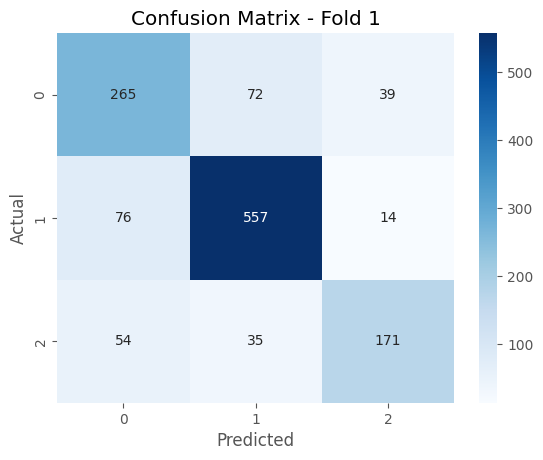

Fold 2
  Accuracy: 0.7677
  Classification Report:
              precision    recall  f1-score   support

           0     0.6675    0.6782    0.6728       376
           1     0.8534    0.8454    0.8494       647
           2     0.7038    0.7038    0.7038       260

    accuracy                         0.7677      1283
   macro avg     0.7416    0.7425    0.7420      1283
weighted avg     0.7686    0.7677    0.7681      1283



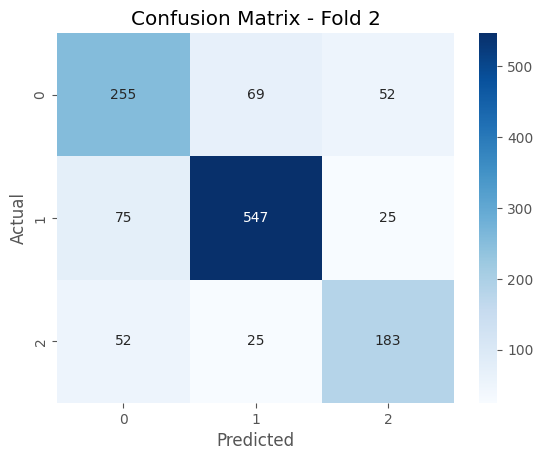

Fold 3
  Accuracy: 0.7793
  Classification Report:
              precision    recall  f1-score   support

           0     0.6649    0.6862    0.6754       376
           1     0.8690    0.8731    0.8710       646
           2     0.7224    0.6808    0.7010       260

    accuracy                         0.7793      1282
   macro avg     0.7521    0.7467    0.7491      1282
weighted avg     0.7794    0.7793    0.7792      1282



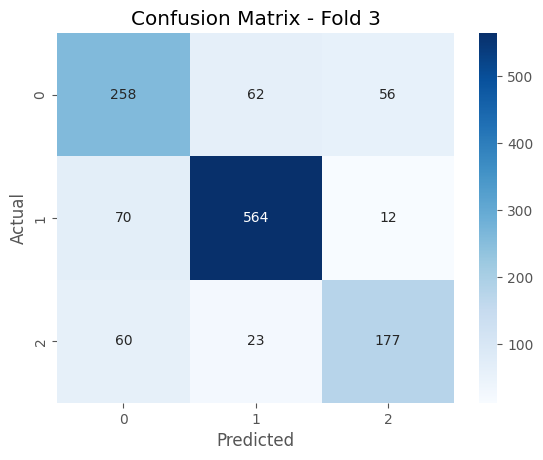


Average CV Accuracy: 0.7737


In [11]:
# Combine enhanced + augmented training features
X_combined = np.vstack((X_train, X_aug))
y_combined = np.hstack((y_train, y_aug))

avg_acc = optimize_hog_parameters(X_combined, y_combined, model_name="Linear SVM", n_splits=3)


Displaying HOG features for sample images...


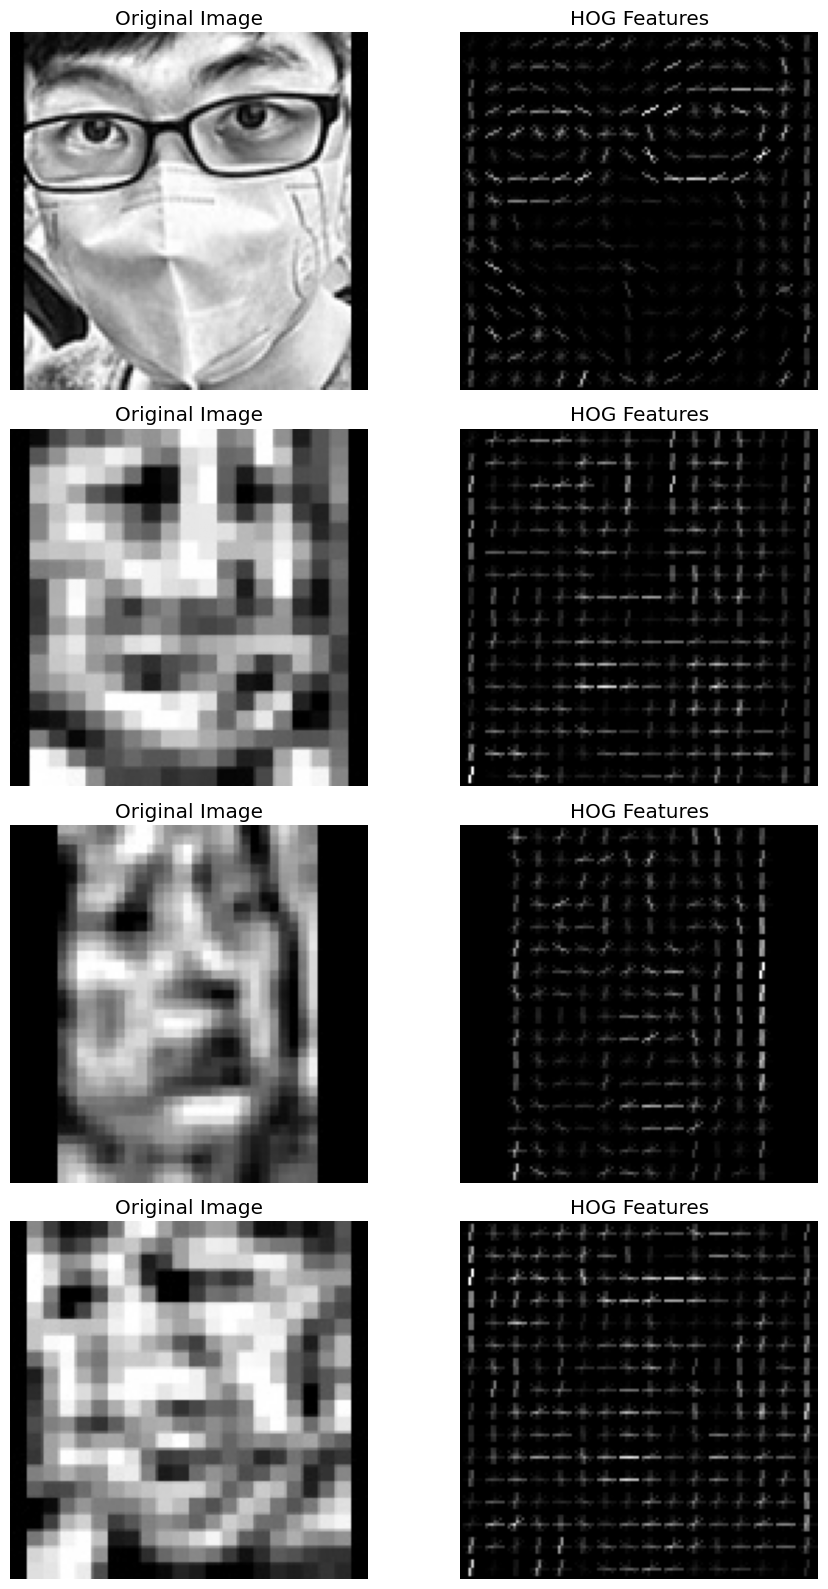

In [12]:
# Visualize HOG features 
print("Displaying HOG features for sample images...")

# path to some training imgs
train_image_dir = str(trainOutputPath)
train_image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpeg')])
train_image_paths = [os.path.join(train_image_dir, f) for f in train_image_files]

# display HOG features for sample imgs
display_sample_hog_features(train_image_paths, hog_params, num_samples=4)

In [13]:
print("\nSummary:")
print(f"- HOG Parameters used: {hog_params}")
print(f"- Feature dimension: {X_train.shape[1]}")
print(f"- Train samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")
if 'X_aug' in locals():
    print(f"- Augmented samples: {len(X_aug)}")



Summary:
- HOG Parameters used: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}
- Feature dimension: 8100
- Train samples: 2394
- Test samples: 458
- Augmented samples: 1454
